# Gold recovery

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

from scipy import interpolate

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate, LeaveOneOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from catboost import CatBoostRegressor
# from keras.models import Sequential
# from keras.layers import Dense

In [2]:
np.random.seed(57)
# STATE = np.random.RandomState(57)

## Task information

The project is provided by the company ["Zyfra"](http://zyfra.com/).

The requirement is to build a model that will predict the recovery rate of gold from gold bearing ore.

This will allow optimization of production so that the enterprise is not started with unprofitable characteristics.

### Technological process

Let's study the process of gold recovery from ore.

When the mined ore undergoes primary processing, a crushed mixture is obtained. It is sent for flotation (beneficiation) and two stages of purification.

1. Flotation

A **mixture of gold bearing ore** is fed into a flotation plant. After beneficiation, **rougher concentrate** and **«tailings»** are obtained. The latter is a residual product with low concentration of valuable metals.

The stability of this process is affected by the <ins>inconsistent and suboptimal physical and chemical state of the flotation slurry</ins> (a mixture of solids and liquid).

2. Cleaning

The rougher concentrate undergoes two purifications. The output is **final concentrate** and **new tailings**.

### Efficiency calculation

Recovery efficiency is calculated by the formula: <a id='formula'></a>

$$
\text{Recovery} = \dfrac{C \times (F - T)}{F \times (C - T)} \times 100\text{%}
$$

where
- C — gold fraction in concentrate after flotation/cleaning
- F — gold fraction in raw material/concentrate before flotation/cleaning
- T — gold fraction in tailings after flotation/cleaning

This coefficient can be calculated for both final concentrate and rougher concentrate.

### Quality Metric

To assess the quality of the model, we can use <ins>Symmetric Mean Absolute Percentage Error</ins> (**sMAPE**):

$$
sMAPE = \dfrac{1}{N} \sum \limits_{i = 1}^{N} \dfrac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|)/2} \times 100 \text{%}
$$

where
- $y_i$ — value of the target attribute for the object with serial number $i$ in the sample on which quality is measured
- $\widehat{y_i}$ — prediction value for the object with serial number $i$, for example, in a test sample
- $N$ — number of objects in the sample

The cumulative deviation is calculated from two values:

$$
\text{Final sMAPE} = 25 \text{%} \times sMAPE(rougher) + 75 \text{%} \times \text{sMAPE(final)}
$$

where
- sMAPE(rougher) — beneficiation efficiency of rougher concentrate
- sMAPE(final) — beneficiation efficiency of final concentrate

### Data structure

Data with extraction and purification parameters are available.

In [3]:
try:
    data_full = pd.read_csv('gold_recovery_full_new.csv')
except:
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [4]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [5]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Here are the data describing
1. Technological process
- Rougher feed — feedstock
- Rougher additions (or reagent additions) — flotation reagents:
    - Xanthate — xanthogenate (promoter, or flotation activator)
    - Sulphate — sulphate (in this production sodium sulphide)
    - Depressant — depressant (sodium silicate)
- Rougher process — flotation
- Rougher tails — tailings
- Float banks — flotation plant
- Cleaner process — cleaning
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate
2. Parameters of stages
- air amount — air volume
- fluid levels — fluid level
- feed size — raw material pellet size
- feed rate — feed rate

In [6]:
features_names = pd.Series(data_full.columns, name='feature')
features_names

0                                           date
1                    final.output.concentrate_ag
2                    final.output.concentrate_pb
3                   final.output.concentrate_sol
4                    final.output.concentrate_au
                         ...                    
82    secondary_cleaner.state.floatbank5_a_level
83      secondary_cleaner.state.floatbank5_b_air
84    secondary_cleaner.state.floatbank5_b_level
85      secondary_cleaner.state.floatbank6_a_air
86    secondary_cleaner.state.floatbank6_a_level
Name: feature, Length: 87, dtype: object

The name of the attributes has the following structure: `stage.parameter_type.parameter_name`.

Stages:
- rougher — flotation
- primary_cleaner — primary cleaning
- secondary_cleaner — secondary cleaning
- final — final characteristics

Parameter types:
- input — raw material parameters
- output — product parameters
- state — parameters characterizing the current state of the stage
- calculation — calculation characteristics

Parameter names can be as follows:

In [7]:
parameters = []
for i in features_names:
    parameters.append(i.split('.')[-1])
parameters = pd.Series(parameters, name='parameters')
print(parameters)
print(len(parameters.unique()))

0                   date
1         concentrate_ag
2         concentrate_pb
3        concentrate_sol
4         concentrate_au
             ...        
82    floatbank5_a_level
83      floatbank5_b_air
84    floatbank5_b_level
85      floatbank6_a_air
86    floatbank6_a_level
Name: parameters, Length: 87, dtype: object
65


In [8]:
data_full[['final.output.tail_au', 'secondary_cleaner.output.tail_au']].head()

,final.output.tail_au,secondary_cleaner.output.tail_au
0,2.143149,2.606185
1,2.224930,2.488248
2,2.257889,2.458187
3,2.146849,2.322062
4,2.055292,2.330448


It is not really clear why there are more tailings after secondary treatment than overall.

## Functions

Let's calculate the [recovery](#formula):

In [9]:
def recovery(dataset, stage='final'):
    C = stage + '.output.concentrate_au'
    T = stage + '.output.tail_au'
    if stage == 'rougher':
        F = 'rougher.input.feed_au'
    elif stage == 'primary_cleaner':
        F = 'rougher.output.concentrate_au'
    elif stage == 'secondary_cleaner'or stage == 'final':
        C = 'final.output.concentrate_au'
        F = 'primary_cleaner.output.concentrate_au'
        T = 'final.output.tail_au'
    else:
        raise ValueError('Stage is incorrect')
    
    return pd.Series((
        dataset[C] * (dataset[F] - dataset[T])
    ) / (
        dataset[F] * (dataset[C] - dataset[T])
    ) * 100, name='recovery')

In [10]:
pd.concat([recovery(data_full, stage='rougher'), 
           data_full['rougher.output.recovery']], axis=1)

,recovery,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
19434,89.574376,89.574376
19435,87.724007,87.724007
19436,88.890579,88.890579
19437,89.858126,89.858126


In [11]:
print(mae(data_full['rougher.output.recovery'], recovery(data_full, stage='rougher')))

9.874045668302637e-15


The error occurs because Python stores fractional numbers in decimal form.

In [12]:
def smape(tar, pred):
    tar = pd.Series(tar).sort_index().reset_index(drop=True)
    pred = pd.Series(pred).sort_index().reset_index(drop=True)
    if len(tar) == len(pred):
        return 1/len(tar) * np.sum(( 
            np.abs(tar - pred)
        ) / (
            (np.abs(tar) + np.abs(pred)) / 2
        )) * 100
    else:
        raise ValueError('Length is not equal')
        
smape_scorer = {
    'r2': 'r2', 
    'smape': make_scorer(smape, greater_is_better=False)
}

In [13]:
def plant_a_tree(ft_train, tg_train):
    best_model = None
    best_depth = 0
    best_scores = {'test_smape': np.array([100])}
        
    for depth in range(1, 20):
        model = DecisionTreeRegressor(max_depth=depth)
        scores = cross_validate(model, ft_train, tg_train, scoring=smape_scorer)
        # print(scores['test_smape'].mean())
        if scores['test_smape'].mean() < best_scores['test_smape'].mean():
            best_model = model
            best_depth = depth
            best_scores = scores
            
    return best_model, best_scores, best_depth

In [14]:
def plant_a_forest(ft_train, tg_train):
    best_model = None
    best_scores = {'test_smape': np.array([100])}
    best_depth = 0
    best_est = 0
    for depth in range(1, 30, 7):
        best_est_model = None
        best_est_scores = {'test_smape': np.array([100])}
        best_est_est = 0
        for est in range(1, 102, 20):
            model = RandomForestRegressor(n_estimators=est, max_depth=depth)
            scores = cross_validate(model, ft_train, tg_train, scoring=smape_scorer)
            if scores['test_smape'].mean() < best_est_scores['test_smape'].mean():
                best_est_model = model
                best_est_scores = scores
                best_est_est = est
        if best_est_scores['test_smape'].mean() < best_scores['test_smape'].mean():
            best_model = best_est_model
            best_scores = best_est_scores
            best_est = best_est_est
            best_depth = depth
    return best_model, best_scores, best_depth, best_est

## Data preprocessing

Let's look at the proposed data.

### Samples

The following sampling breakdown is suggested:

In [15]:
try:
    data_train = pd.read_csv('gold_recovery_train_new.csv')
    data_test = pd.read_csv('gold_recovery_test_new.csv')
except:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [16]:
print(data_train.shape)
print(data_test.shape)

(14149, 87)
(5290, 53)


Looks like the test sample was given without the target feature. I wonder what was excluded.

In [17]:
print(features_names[~features_names.isin(data_test.columns)])

1                           final.output.concentrate_ag
2                           final.output.concentrate_pb
3                          final.output.concentrate_sol
4                           final.output.concentrate_au
5                                 final.output.recovery
6                                  final.output.tail_ag
7                                  final.output.tail_pb
8                                 final.output.tail_sol
9                                  final.output.tail_au
14                primary_cleaner.output.concentrate_ag
15                primary_cleaner.output.concentrate_pb
16               primary_cleaner.output.concentrate_sol
17                primary_cleaner.output.concentrate_au
18                       primary_cleaner.output.tail_ag
19                       primary_cleaner.output.tail_pb
20                      primary_cleaner.output.tail_sol
21                       primary_cleaner.output.tail_au
30        rougher.calculation.sulfate_to_au_conc

For comparison:

In [18]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Expected concentrations of metals and salts in concentrates and tailings were excluded, as well as columns calculating gold recovery and concentration ratios between metals and salts.

According the column names, these are characteristics that are calculated after the end of the process, so it would be incorrect to use them for prediction.

Let's briefly make sure that the samples are taken from a common data set.

In [19]:
print(data_full['rougher.input.feed_ag'].sum())
print(data_train['rougher.input.feed_ag'].sum() + data_test['rougher.input.feed_ag'].sum())

170964.59423041172
170964.59423041172


For testing, the target feature is also needed. Let's take the same rows from the common dataset.

In [20]:
data_train = data_full.loc[data_full['date'].isin(data_train['date'])]
data_test = data_full.loc[data_full['date'].isin(data_test['date'])]

In [21]:
data_test.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
4682,2016-09-01 00:59:59,7.578381,10.466295,11.990938,40.743891,70.273583,12.688885,3.844413,11.075686,4.537988,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
4683,2016-09-01 01:59:59,7.813838,10.581152,12.216172,39.604292,68.910432,12.829171,3.918901,11.132824,4.675117,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
4684,2016-09-01 02:59:59,7.623392,10.424024,12.313710,40.724190,68.143213,12.977846,4.026561,10.990134,4.828907,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
4685,2016-09-01 03:59:59,8.552457,10.503229,13.074570,39.290997,67.776393,12.451947,3.780702,11.155935,4.969620,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4686,2016-09-01 04:59:59,8.078781,10.222788,12.475427,40.254524,61.467078,11.827846,3.632272,11.403663,5.256806,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


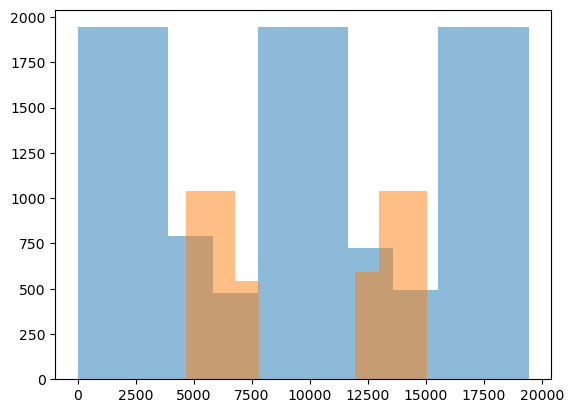

In [22]:
plt.hist(data_train.index, alpha=0.5)
plt.hist(data_test.index, alpha=0.5)
plt.show()

### Data Types

In [23]:
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%d %H:%M:%S')
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')

/tmp/ipykernel_5561/515856303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_5561/515856303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')


In [24]:
len(data_full['date'].unique())

19439

The dates are not repeated, we can navigate by them.

In [25]:
data_full = data_full.set_index('date')
data_train = data_train.set_index('date')
data_test = data_test.set_index('date')

/home/leonid/anaconda3/envs/practicum/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


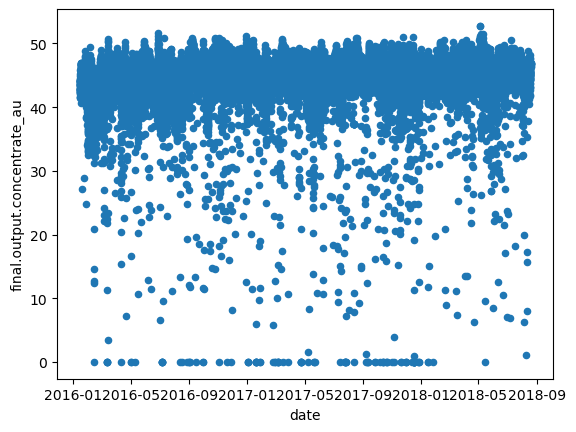

In [26]:
(data_full
 .sort_index()
 .reset_index()
 .plot(kind='scatter', 
       x='date', 
       y='final.output.concentrate_au'));

Almost 3 years of observations.

### Missing values

In [27]:
data_full.isna().sum().sort_values(ascending=False).head(10)

secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
final.output.concentrate_sol                 211
rougher.input.feed_size                      145
primary_cleaner.output.concentrate_pb        116
primary_cleaner.input.xanthate               104
final.output.tail_pb                         101
dtype: int64

Let's look at the distributions of the missing features.

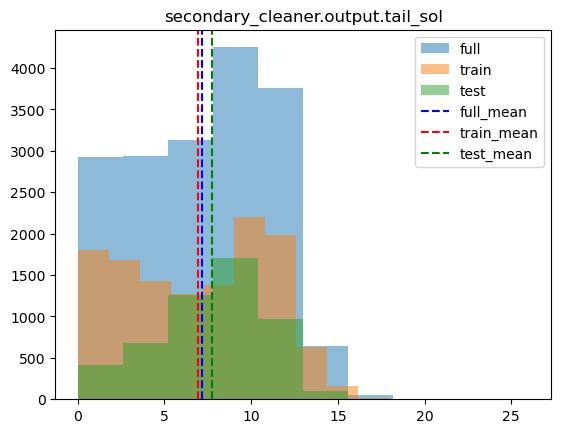

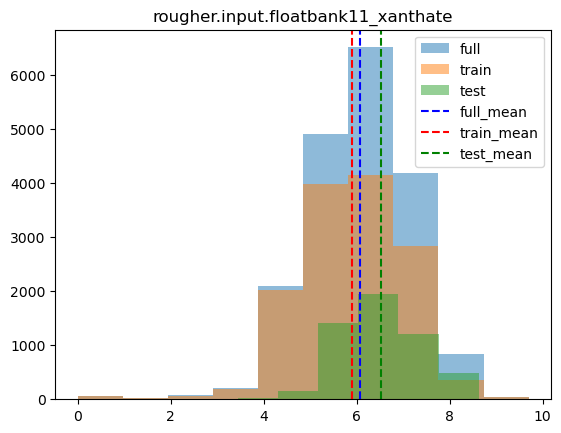

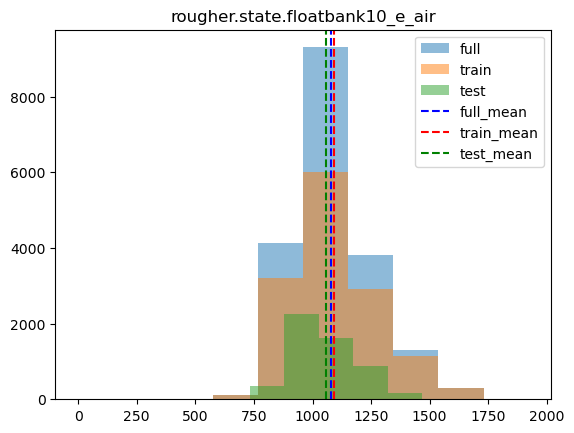

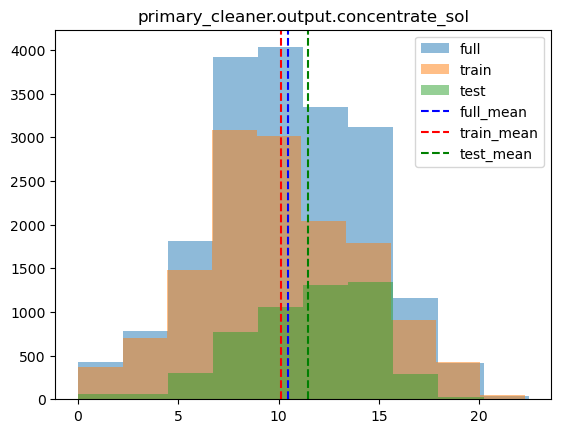

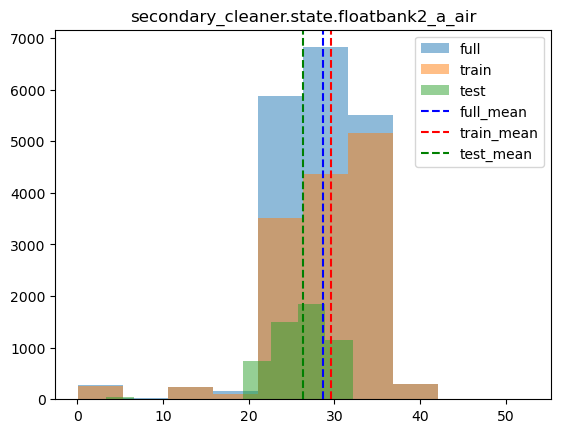

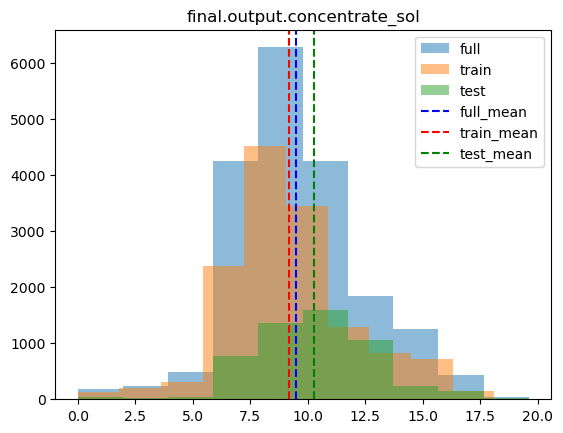

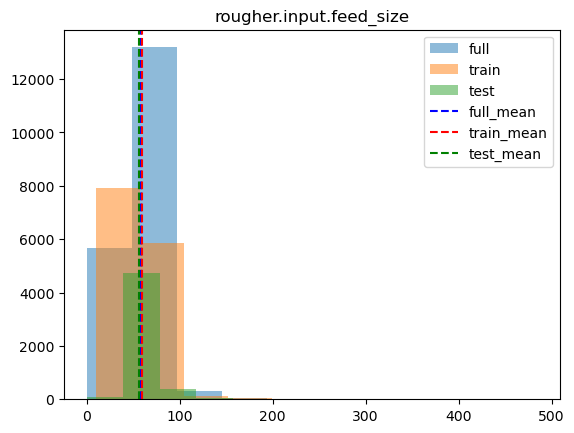

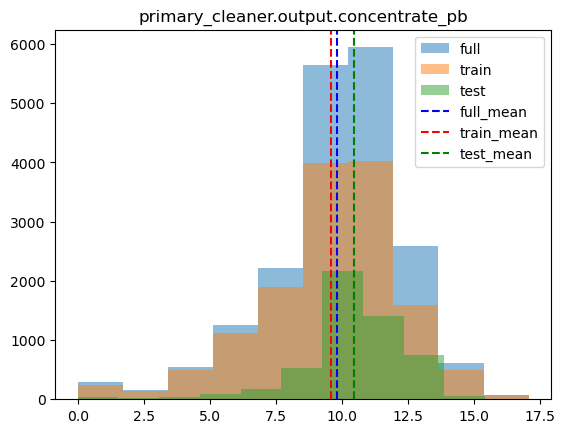

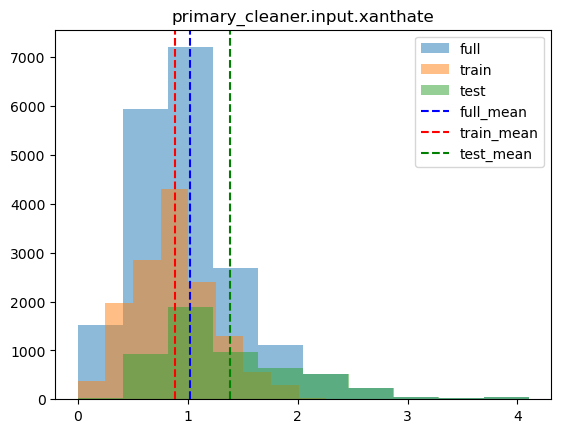

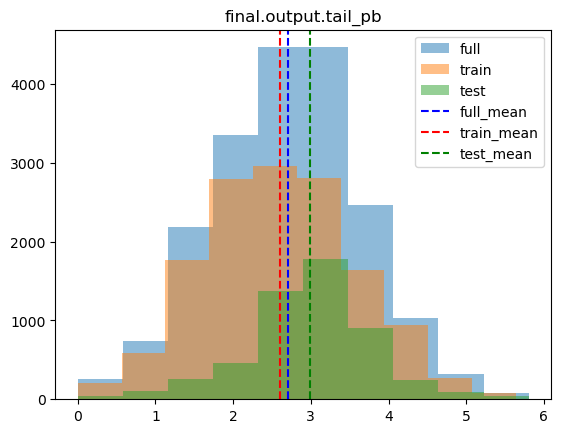

In [28]:
top_list = data_full.isna().sum().sort_values(ascending=False).head(10).index
for column in top_list:
    plt.hist(data_full[column], alpha=0.5, label='full')
    plt.hist(data_train[column], alpha=0.5, label='train')
    plt.hist(data_test[column], alpha=0.5, label='test')
    plt.axvline(x=data_full[column].mean(), color='blue', ls='--', label='full_mean')
    plt.axvline(x=data_train[column].mean(), color='red', ls='--', label='train_mean')
    plt.axvline(x=data_test[column].mean(), color='green', ls='--', label='test_mean')
    plt.title(column)
    plt.legend()
    plt.show()

To decide whether the gaps can be replaced by a measure of central tendency, let's look at the dynamics of the characteristics over time.

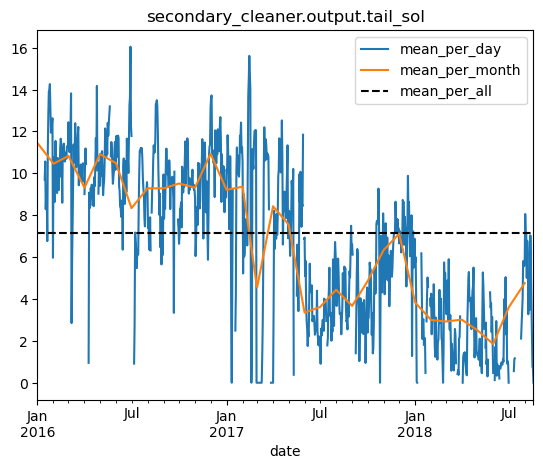

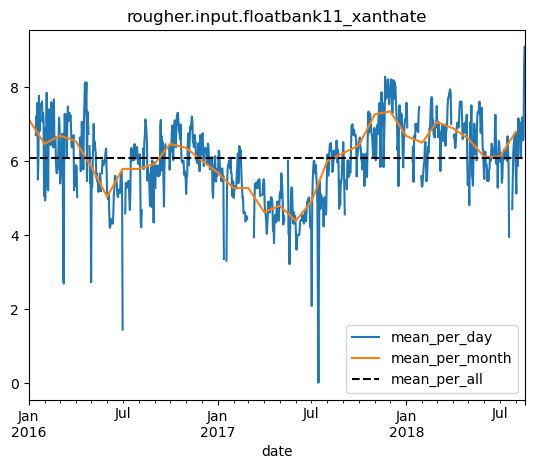

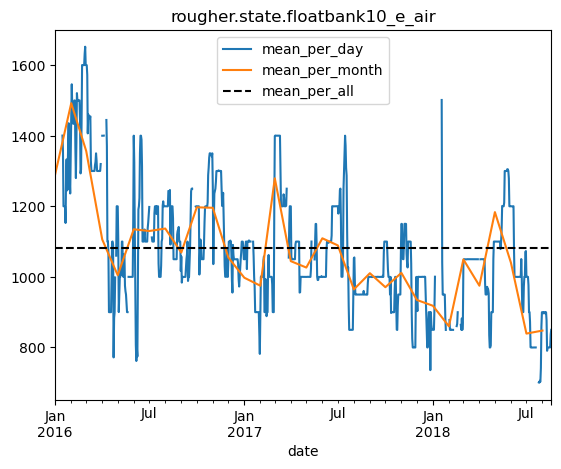

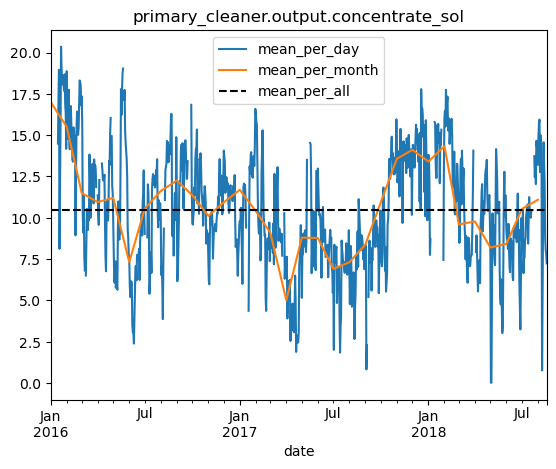

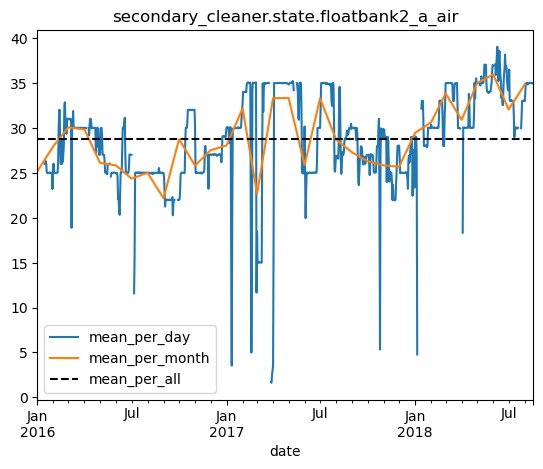

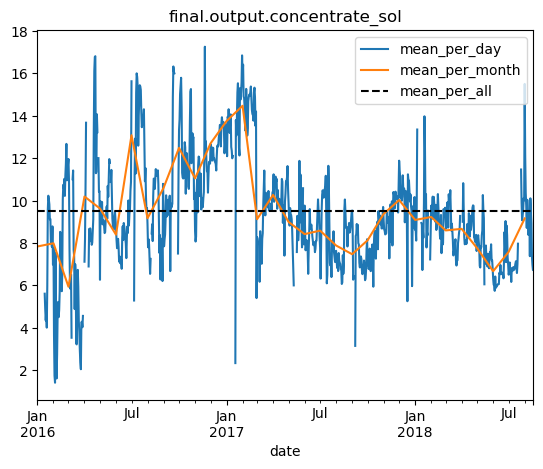

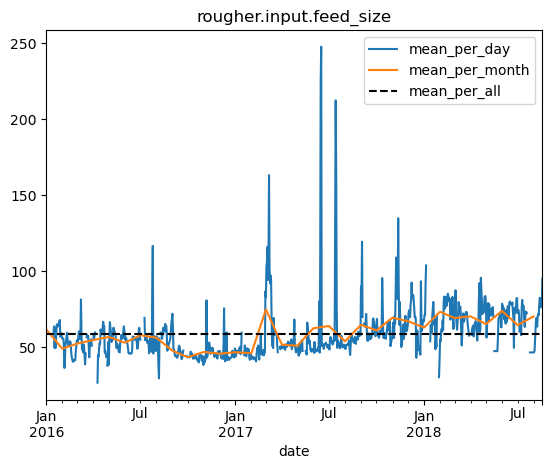

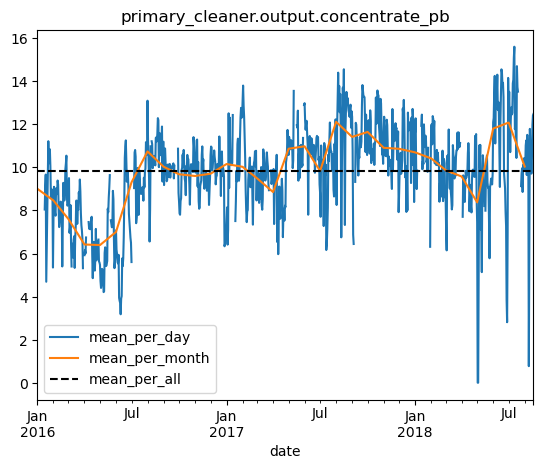

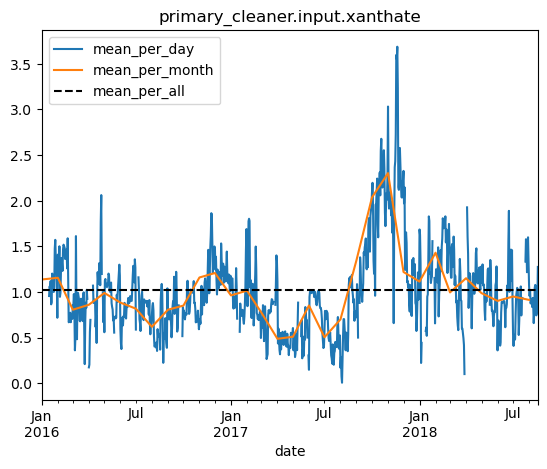

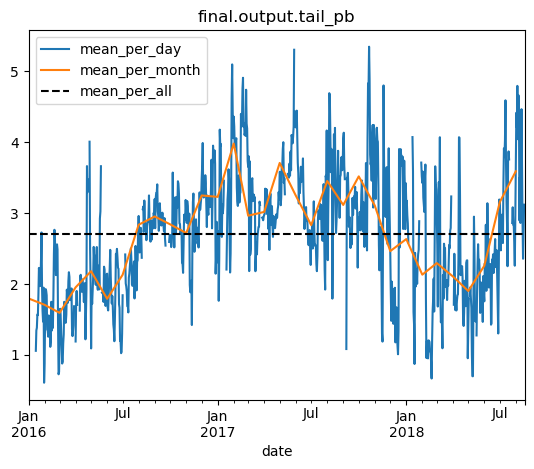

In [29]:
top_list = data_full.isna().sum().sort_values(ascending=False).head(10).index
for column in top_list:
    # data_full[column].resample('H').mean().plot(label='mean_per_hour')
    data_full[column].resample('D').mean().plot(label='mean_per_day')
    data_full[column].resample('M').mean().plot(label='mean_per_month')
    plt.axhline(y=data_full[column].mean(), color='black', ls='--', label='mean_per_all')
    plt.title(column)
    plt.legend()
    plt.show()

In [30]:
data_full.isna().sum().sum()

4481

Filling in the blanks with the median would not be a good option here because the data reflect changes over time.

Let's replace them with interpolation. Since the data can vary widely even between neighboring points, polynomial interpolation will predict better than linear interpolation.

In [31]:
data_full = data_full.interpolate(method='polynomial', order=2)
data_train = data_train.interpolate(method='polynomial', order=2)
data_test = data_test.interpolate(method='polynomial', order=2)

In [32]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         5290 non-null   float64
 1   final.output.concentrate_pb                         5290 non-null   float64
 2   final.output.concentrate_sol                        5290 non-null   float64
 3   final.output.concentrate_au                         5290 non-null   float64
 4   final.output.recovery                               5290 non-null   float64
 5   final.output.tail_ag                                5290 non-null   float64
 6   final.output.tail_pb                                5290 non-null   float64
 7   final.output.tail_sol                               5290 non-null   float64
 8   final.output.tail_au                      

### Duplicates

In [33]:
print(data_full.duplicated().sum())
print(data_train.duplicated().sum())
print(data_test.duplicated().sum())

0
0
0


### Feature selection

I think we would need a model for each of the stages. Because the output at each stage depends only on the parameters of that stage, not the subsequent ones.

And for each of these models, we'll need a different pair of datasets.

In [34]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                     

In [35]:
features_train_rougher = data_train.filter(regex='rougher.input|rougher.state')
features_test_rougher = data_test.filter(regex='rougher.input|rougher.state')
target_train_rougher = data_train['rougher.output.recovery']
target_test_rougher = data_test['rougher.output.recovery']

features_train_final = data_train.filter(regex='''
primary_cleaner.input|\
primary_cleaner.state|\
primary_cleaner.state
''')
features_test_final = data_test.filter(regex='''
primary_cleaner.input|\
primary_cleaner.state|\
primary_cleaner.state
''')
target_train_final = data_train['final.output.recovery']
target_test_final = data_test['final.output.recovery']

In [36]:
features_train_rougher.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               14149 non-null  float64
 1   rougher.input.feed_pb               14149 non-null  float64
 2   rougher.input.feed_rate             14149 non-null  float64
 3   rougher.input.feed_size             14149 non-null  float64
 4   rougher.input.feed_sol              14149 non-null  float64
 5   rougher.input.feed_au               14149 non-null  float64
 6   rougher.input.floatbank10_sulfate   14149 non-null  float64
 7   rougher.input.floatbank10_xanthate  14149 non-null  float64
 8   rougher.input.floatbank11_sulfate   14149 non-null  float64
 9   rougher.input.floatbank11_xanthate  14149 non-null  float64
 10  rougher.state.floatbank10_a_air     14149 non-null  float64
 11  roughe

In [37]:
target_test_final

date
2016-09-01 00:59:59    70.273583
2016-09-01 01:59:59    68.910432
2016-09-01 02:59:59    68.143213
2016-09-01 03:59:59    67.776393
2016-09-01 04:59:59    61.467078
                         ...    
2017-12-31 19:59:59    68.919891
2017-12-31 20:59:59    68.440582
2017-12-31 21:59:59    67.092759
2017-12-31 22:59:59    68.061186
2017-12-31 23:59:59    71.699976
Name: final.output.recovery, Length: 5290, dtype: float64

### Scaling

In [38]:
scaler = StandardScaler()
scaler.fit(features_train_rougher)
features_train_rougher = pd.DataFrame(scaler.transform(features_train_rougher), 
                                      index=features_train_rougher.index, 
                                      columns=features_train_rougher.columns)
features_test_rougher = pd.DataFrame(scaler.transform(features_test_rougher), 
                                         index=features_test_rougher.index, 
                                         columns=features_test_rougher.columns)
print(features_train_rougher.shape)
print(features_test_rougher.shape)

(14149, 22)
(5290, 22)


In [39]:
scaler = StandardScaler()
scaler.fit(features_train_final)
features_train_final = pd.DataFrame(scaler.transform(features_train_final), 
                                      index=features_train_final.index, 
                                      columns=features_train_final.columns)
features_test_final = pd.DataFrame(scaler.transform(features_test_final), 
                                         index=features_test_final.index, 
                                         columns=features_test_final.columns)
print(features_train_final.shape)
print(features_test_final.shape)

(14149, 8)
(5290, 8)


## Exploratory data analysis

Let's look at metal concentrations in tailings and concentrates, pellet size.

### Concentrations of metals at different stages.

To group the data, we select all `rougher.input.feed_` columns with metals, as well as `rougher.output.concentrate_ `, `primary_cleaner.output.concentrate_` and `final.output.concentrate_`.

In [40]:
df_for_pivot = pd.DataFrame(data_full.filter(regex=
'''\
rougher.input.feed_..$|rougher.input.feed_sol$|\
rougher.output.concentrate_.*|\
primary_cleaner.output.concentrate_.*|\
final.output.concentrate_.*\
''').stack(), columns=['value'])
df_for_pivot['feature'] = df_for_pivot.index.get_level_values(1)
df_for_pivot = df_for_pivot.droplevel(1)
df_for_pivot.head()

,value,feature
date,,
2016-01-15,6.055403,final.output.concentrate_ag
2016-01-15,9.889648,final.output.concentrate_pb
2016-01-15,5.507324,final.output.concentrate_sol
2016-01-15,42.192020,final.output.concentrate_au
2016-01-15,8.547551,primary_cleaner.output.concentrate_ag


In [41]:
df_for_pivot['metal'] = df_for_pivot['feature'].apply(lambda x: x.split('_')[-1])
df_for_pivot['stage'] = df_for_pivot['feature'].apply(lambda x: 'feed' if 'feed' in x 
                                                      else x.split('.')[0])
df_for_pivot = df_for_pivot.drop('feature', axis=1)
df_for_pivot.head()

,value,metal,stage
date,,,
2016-01-15,6.055403,ag,final
2016-01-15,9.889648,pb,final
2016-01-15,5.507324,sol,final
2016-01-15,42.192020,au,final
2016-01-15,8.547551,ag,primary_cleaner


In [42]:
df_pivot = df_for_pivot.pivot_table(values='value', index=['stage', 'metal'], aggfunc='mean')
df_pivot = df_pivot.unstack().droplevel(0, axis=1)
df_pivot = df_pivot.reindex(index=['feed', 'rougher', 'primary_cleaner', 'final'])
df_pivot

metal,ag,au,pb,sol
stage,,,,
feed,8.794927,8.266097,3.573164,36.659828
rougher,11.994759,19.772000,7.606272,28.805371
primary_cleaner,8.442408,32.119400,9.806420,10.372783
final,5.168385,44.076513,9.978813,9.424201


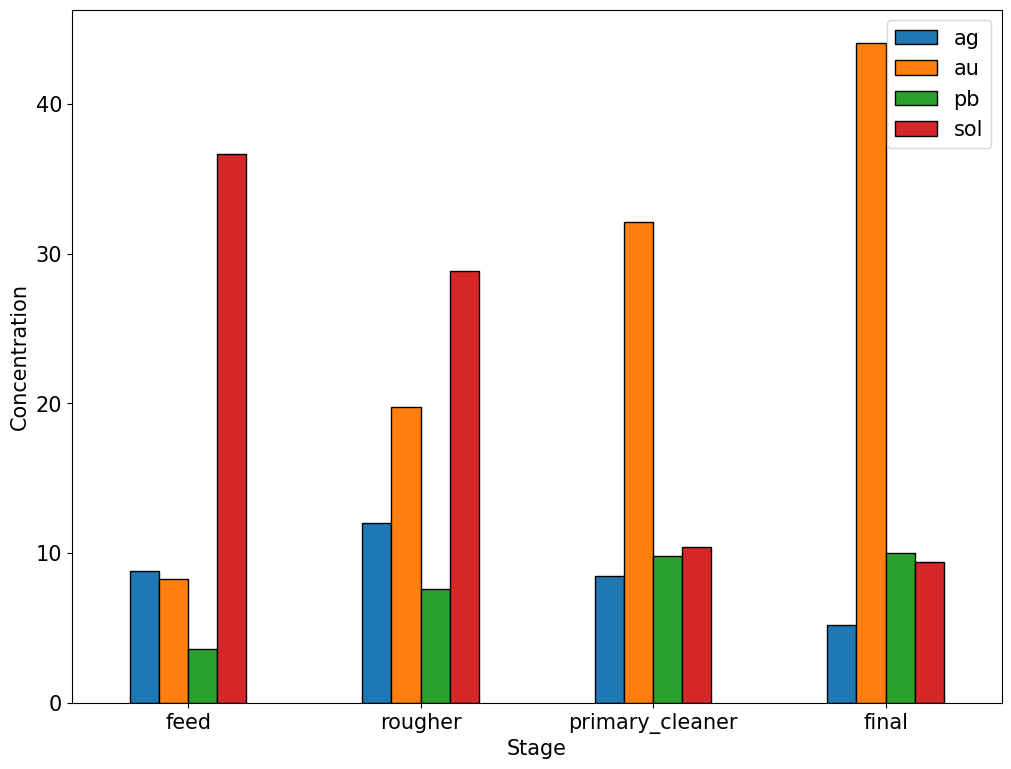

In [43]:
df_pivot.plot(kind='bar', edgecolor='black', figsize=(12, 9))
plt.xlabel('Stage', fontsize=15)
plt.ylabel('Concentration', fontsize=15)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

From here we can sum the total concentration:

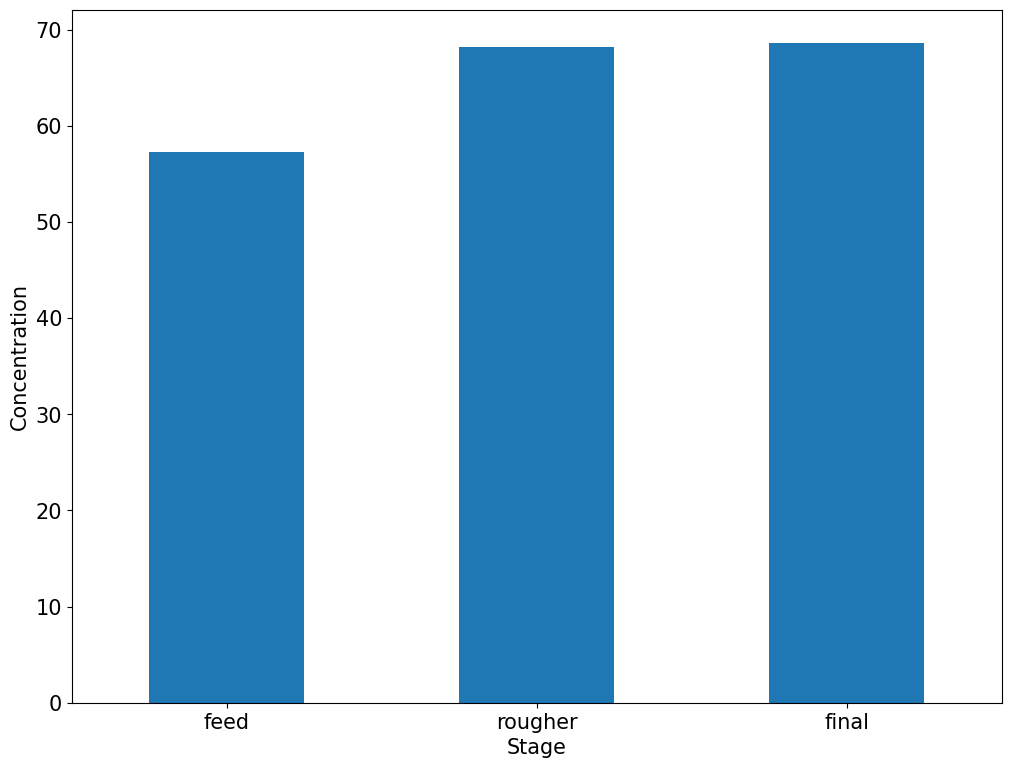

In [44]:
df_pivot.sum(axis=1).drop('primary_cleaner').plot(kind='bar', figsize=(12, 9))
plt.xlabel('Stage', fontsize=15)
plt.ylabel('Concentration', fontsize=15)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15)
plt.show()

Let's see how the total concentrations are distributed.

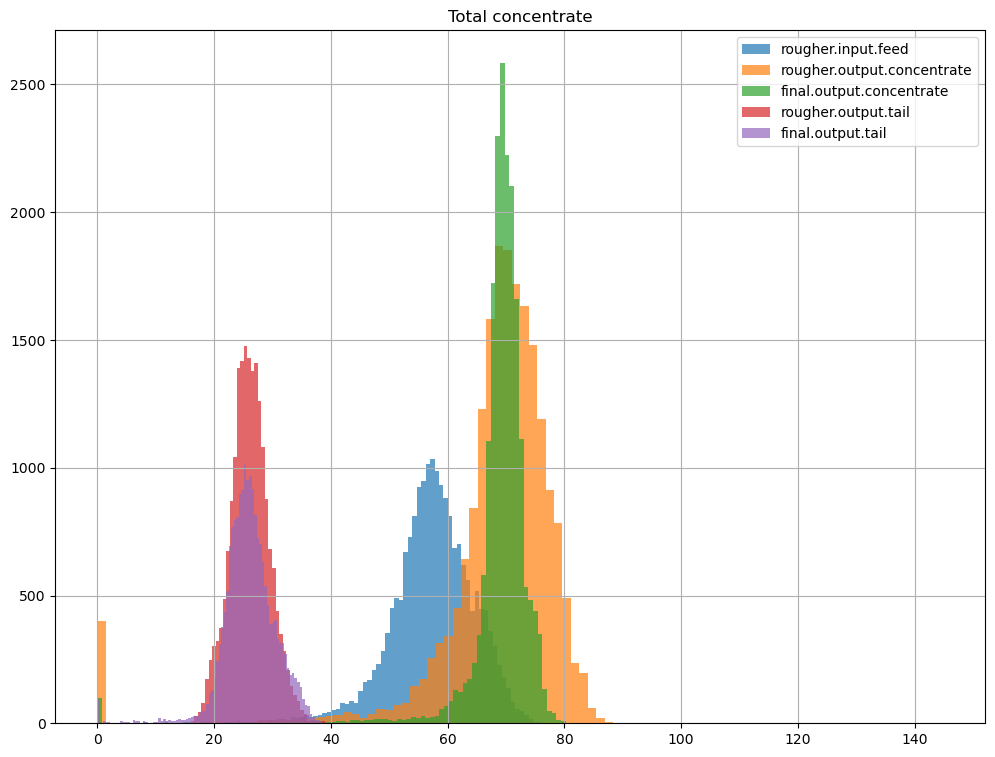

In [45]:
plt.figure(figsize=(12, 9))
for label in ['rougher.input.feed_..$|rougher.input.feed_...$',
              'rougher.output.concentrate_', 'final.output.concentrate_', 
              'rougher.output.tail_', 'final.output.tail_']:
    (data_full.filter(regex=label).sum(axis=1)
     .hist(bins=100, label=label.split('_')[0], alpha=0.7))
plt.title('Total concentrate')
plt.legend()
plt.show()

<a id='hist'>

Now to the most common range of concentrations.

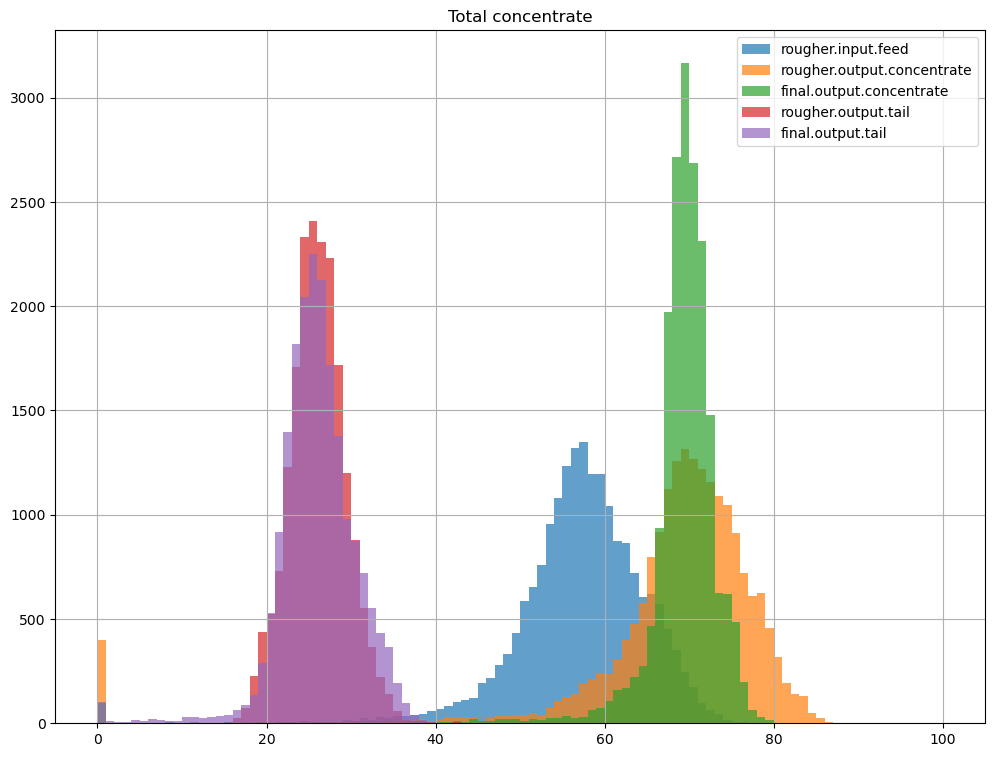

In [46]:
plt.figure(figsize=(12, 9))
for label in ['rougher.input.feed_..$|rougher.input.feed_...$',
              'rougher.output.concentrate_', 'final.output.concentrate_', 
              'rougher.output.tail_', 'final.output.tail_']:
    (data_full.filter(regex=label).sum(axis=1)
     .hist(bins=100, label=label.split('_')[0], alpha=0.7, range=(0, 100)))
plt.title('Total concentrate')
plt.legend()
plt.show()

It can be seen that the concentrations in the tailings after flotation and cleaning are almost the same. Whereas the final concentration is not even higher than the intermediate one, just more precise.

Rows with zero concentration will interfere during training. We will have to throw them out, but first, let's see if this is related to the weekends.

In [47]:
data_full[data_full['rougher.output.concentrate_au'] == 0].index.weekday.value_counts()

2    84
0    75
1    68
6    51
3    45
4    45
5    26
Name: date, dtype: int64

Apparently not.

In [48]:
def drop_from_all(index_to_drop):
    # data_full = data_full.loc[~data_full.index.isin(index_to_drop)]
    
    data_full.drop(index_to_drop, inplace=True, errors='ignore')
    data_train.drop(index_to_drop, inplace=True, errors='ignore')
    data_test.drop(index_to_drop, inplace=True, errors='ignore')

    features_train_rougher.drop(index_to_drop, inplace=True, errors='ignore')
    features_test_rougher.drop(index_to_drop, inplace=True, errors='ignore')
    target_train_rougher.drop(index_to_drop, inplace=True, errors='ignore')
    target_test_rougher.drop(index_to_drop, inplace=True, errors='ignore')    

    features_train_final.drop(index_to_drop, inplace=True, errors='ignore')
    features_test_final.drop(index_to_drop, inplace=True, errors='ignore')    
    target_train_final.drop(index_to_drop, inplace=True, errors='ignore')
    target_test_final.drop(index_to_drop, inplace=True, errors='ignore')

In [49]:
zero_index = data_full[(data_full.filter(regex='''\
rougher.output.concentrate_|\
rougher.output.tail_|\
final.output.concentrate_|\
final.output.tail_''') == 0).any(axis=1)].index
zero_index

DatetimeIndex(['2016-01-16 21:00:00', '2016-01-16 22:00:00',
               '2016-01-16 23:00:00', '2016-01-17 00:00:00',
               '2016-01-17 02:00:00', '2016-01-17 03:00:00',
               '2016-01-17 04:00:00', '2016-01-18 05:00:00',
               '2016-02-13 11:00:00', '2016-02-18 20:00:00',
               ...
               '2018-06-06 22:59:59', '2018-06-06 23:59:59',
               '2018-06-10 23:59:59', '2018-06-11 07:59:59',
               '2018-06-14 03:59:59', '2018-06-19 20:59:59',
               '2018-06-23 18:59:59', '2018-07-31 16:59:59',
               '2018-08-08 04:59:59', '2018-08-08 05:59:59'],
              dtype='datetime64[ns]', name='date', length=580, freq=None)

In [50]:
drop_from_all(zero_index)

### Comparison of training and test samples

In [51]:
data_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Let's have a look at the distributions of the pellet size data.

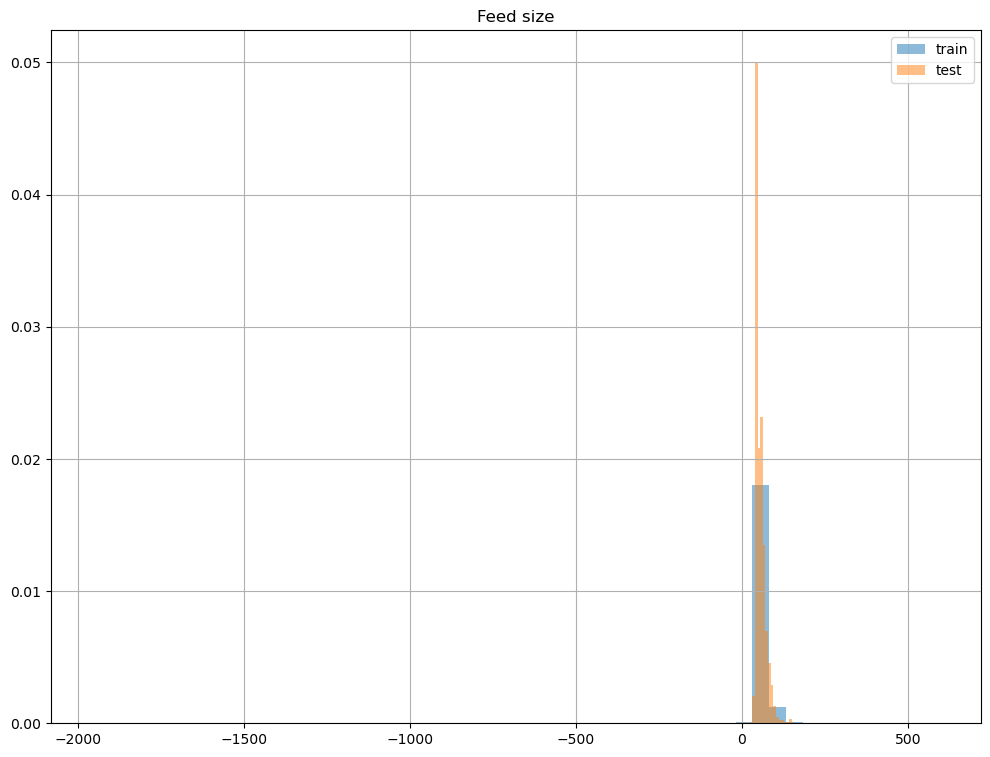

In [52]:
plt.figure(figsize=(12, 9))
data_train['rougher.input.feed_size'].hist(label='train', alpha=0.5, bins=50, density=True)
data_test['rougher.input.feed_size'].hist(label='test', alpha=0.5, bins=50, density=True)
plt.title('Feed size')
plt.legend()
plt.show()

Without outliers:

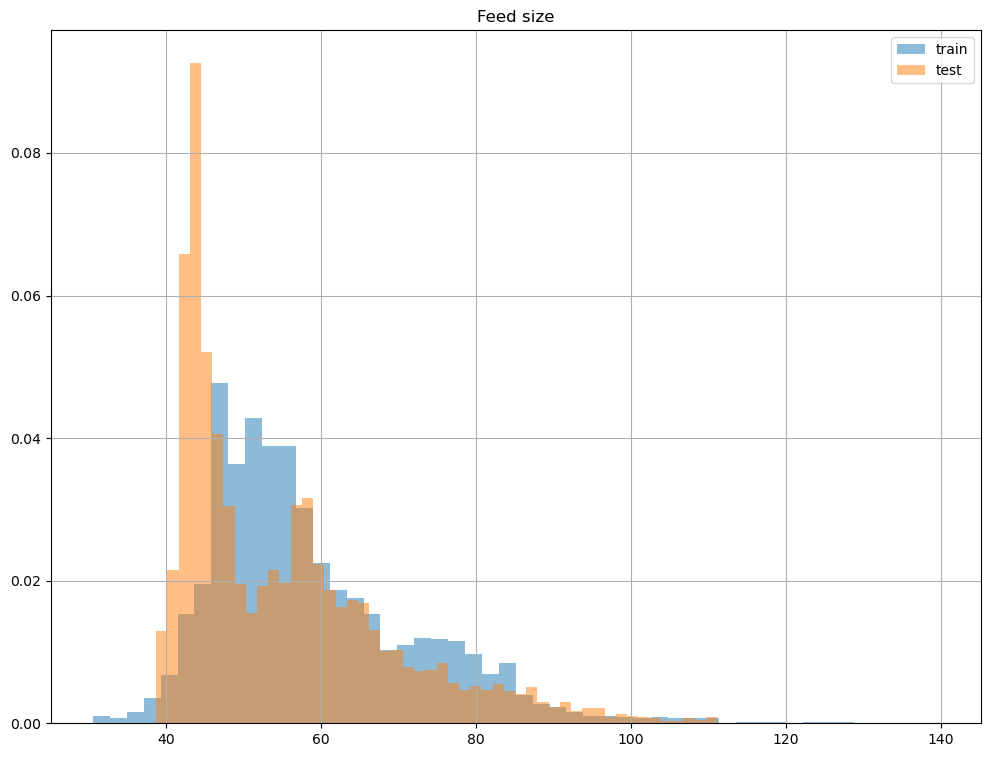

In [53]:
plt.figure(figsize=(12, 9))
df_train = (data_train.loc[(data_train['rougher.input.feed_size'].quantile(0.01) < 
                            data_train['rougher.input.feed_size']) & 
                           (data_train['rougher.input.feed_size'] < 
                            data_train['rougher.input.feed_size'].quantile(0.99))])
df_test = (data_test.loc[(data_test['rougher.input.feed_size'].quantile(0.01) < 
                            data_test['rougher.input.feed_size']) & 
                           (data_test['rougher.input.feed_size'] < 
                            data_test['rougher.input.feed_size'].quantile(0.99))])
df_train['rougher.input.feed_size'].hist(label='train', alpha=0.5, bins=50, density=True)
df_test['rougher.input.feed_size'].hist(label='test', alpha=0.5, bins=50, density=True)
plt.title('Feed size')
plt.legend()
plt.show()

In [54]:
data_train[data_train['rougher.input.feed_size'] < 0]['rougher.input.feed_size']

date
2016-07-06 10:59:59   -1948.839203
2016-07-06 11:59:59   -1951.818054
2016-07-06 13:59:59   -1955.350361
2016-07-06 14:59:59   -1955.903817
2016-07-06 15:59:59   -1955.648808
                          ...     
2016-07-09 07:59:59    -257.721520
2016-07-09 08:59:59    -204.916301
2016-07-09 09:59:59    -151.302617
2016-07-09 10:59:59     -96.880468
2016-07-09 11:59:59     -41.649855
Name: rougher.input.feed_size, Length: 66, dtype: float64

A negative pellet size is most likely an anomaly.

In [55]:
neg_size_index = data_full[data_full['rougher.input.feed_size'] < 0].index

drop_from_all(neg_size_index)

Now it's on to the feed rate.

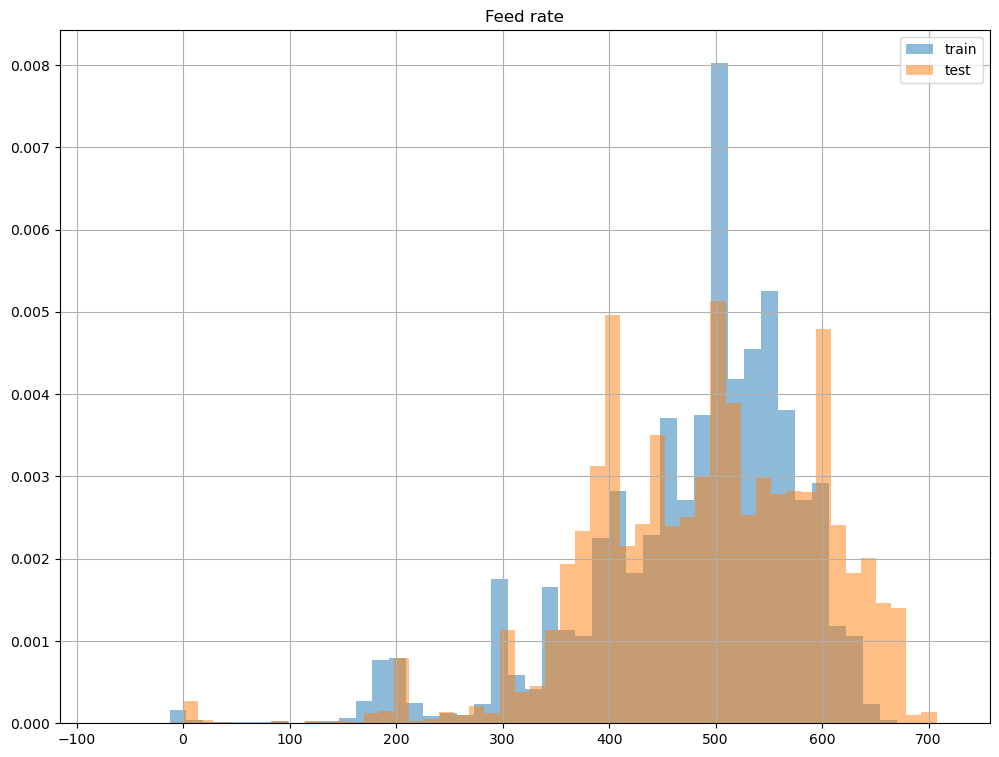

In [56]:
plt.figure(figsize=(12, 9))
data_train['rougher.input.feed_rate'].hist(label='train', alpha=0.5, bins=50, density=True)
data_test['rougher.input.feed_rate'].hist(label='test', alpha=0.5, bins=50, density=True)
plt.title('Feed rate')
plt.legend()
plt.show()

In [57]:
data_train[data_train['rougher.input.feed_rate'] < 0]['rougher.input.feed_rate']

date
2018-02-23 14:59:59   -68.492473
2018-03-29 11:59:59   -32.315495
2018-07-05 16:59:59   -16.153329
2018-07-15 20:59:59   -76.224153
Name: rougher.input.feed_rate, dtype: float64

In [58]:
neg_rate_index = data_full[data_full['rougher.input.feed_rate'] < 0].index

drop_from_all(neg_rate_index)

The distributions of the training and test samples vary quite significantly, but the samples are fixed by the task formulation, so we will train on these.

## Training

We will calculate the target metric as follows:

In [59]:
def final_smape(rougher_model, final_model, 
                features_rougher=features_train_rougher, 
                target_rougher=target_train_rougher,
                features_final=features_train_final, 
                target_final=target_train_final):
    rougher_smape = -cross_validate(rougher_model, features_rougher, target_rougher, 
                                   scoring=smape_scorer)['test_smape'].mean()
    final_smape = -cross_validate(final_model, features_final, target_final, 
                                 scoring=smape_scorer)['test_smape'].mean()
    return 0.25 * rougher_smape + 0.75 * final_smape

For each of the steps, we will consider linear regression, a decision tree, and a random forest.

In all cases, with a cross-validation.

### Linear Regression.

In [60]:
rougher_model = LinearRegression()
rougher_scores = cross_validate(rougher_model, features_train_rougher, 
                                target_train_rougher, scoring=smape_scorer)
print('Rougher')
print('='*9)
print('R2:', rougher_scores['test_r2'].mean())
print(rougher_scores['test_r2'])
print()
print('sMAPE (%):', -rougher_scores['test_smape'].mean())
print(-rougher_scores['test_smape'])

Rougher
R2: -2.4955718021941933
[  0.0139714    0.17795946   0.34452227 -12.31592023  -0.69839192]

sMAPE (%): 7.451994437527285
[ 7.74877384  7.55692922  3.72232624 10.21332903  8.01861386]


In [61]:
final_model = LinearRegression()
final_scores = cross_validate(final_model, features_train_final, 
                                target_train_final, scoring=smape_scorer)
print('Final')
print('='*9)
print('R2:', final_scores['test_r2'].mean())
print(final_scores['test_r2'])
print()
print('sMAPE (%):', -final_scores['test_smape'].mean())
print(-final_scores['test_smape'])

Final
R2: -0.16689249153452831
[-0.48107013  0.08744123 -0.25092288  0.02881219 -0.21872287]

sMAPE (%): 10.741610356532439
[11.9039061   8.55184047 10.65294988 11.08771346 11.51164187]


In [62]:
print('Linear Regression')
print(final_smape(rougher_model, final_model))

Linear Regression
9.91920637678115


### Decision Tree

In [63]:
state = np.random.RandomState(57)
param_dict = {'max_depth': range(1, 30)}
rougher_model = DecisionTreeRegressor(random_state=state)
rougher_rsearch = RandomizedSearchCV(rougher_model, param_distributions=param_dict, n_iter=20, 
                                     cv=5, scoring=smape_scorer['smape'], random_state=state)
rougher_rsearch.fit(features_train_rougher, target_train_rougher)

print('Rougher')
print('='*9)
print('Depth:', rougher_rsearch.best_params_['max_depth'])
print('sMAPE:', -rougher_rsearch.best_score_)

Rougher
Depth: 4
sMAPE: 7.2357939261948685


In [64]:
state = np.random.RandomState(57)
param_dict = {'max_depth': range(1, 30)}
final_model = DecisionTreeRegressor(random_state=state)
final_rsearch = RandomizedSearchCV(final_model, param_distributions=param_dict, n_iter=20, 
                                   cv=5, scoring=smape_scorer['smape'], random_state=state)
final_rsearch.fit(features_train_final, target_train_final)

print('Final')
print('='*9)
print('Depth:', final_rsearch.best_params_['max_depth'])
print('sMAPE:', -final_rsearch.best_score_)

Final
Depth: 1
sMAPE: 10.696148904144176


In [65]:
print('Decision Tree Regressor')
print(final_smape(rougher_model, final_model))

Decision Tree Regressor
15.164551276301438


Still getting better than regression.

### Random Forest

In [66]:
state = np.random.RandomState(57)
param_dict = {'max_depth': range(1, 30, 4), 
              'n_estimators': range(100, 501, 100)}
rougher_model = RandomForestRegressor(random_state=state)
rougher_rsearch = RandomizedSearchCV(rougher_model, param_distributions=param_dict, n_iter=3, 
                                     cv=5, scoring=smape_scorer['smape'], verbose=3, random_state=state)
rougher_rsearch.fit(features_train_rougher, target_train_rougher)

print('Rougher')
print('='*9)
print('Depth:', rougher_rsearch.best_params_['max_depth'])
print('Estimators:', rougher_rsearch.best_params_['n_estimators'])
print('sMAPE:', -rougher_rsearch.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................max_depth=9, n_estimators=100; total time=  13.1s
[CV 2/5] END ..................max_depth=9, n_estimators=100; total time=  14.3s
[CV 3/5] END ..................max_depth=9, n_estimators=100; total time=  13.8s
[CV 4/5] END ..................max_depth=9, n_estimators=100; total time=  14.0s
[CV 5/5] END ..................max_depth=9, n_estimators=100; total time=  13.7s
[CV 1/5] END .................max_depth=25, n_estimators=200; total time=  43.5s
[CV 2/5] END .................max_depth=25, n_estimators=200; total time=  44.4s
[CV 3/5] END .................max_depth=25, n_estimators=200; total time=  41.7s
[CV 4/5] END .................max_depth=25, n_estimators=200; total time=  42.9s
[CV 5/5] END .................max_depth=25, n_estimators=200; total time=  43.2s
[CV 1/5] END .................max_depth=17, n_estimators=400; total time= 1.3min
[CV 2/5] END .................max_depth=17, n_est

In [67]:
state = np.random.RandomState(57)
param_dict = {'max_depth': range(1, 30, 4), 
              'n_estimators': range(100, 501, 100)}
final_model = RandomForestRegressor(random_state=state)
final_rsearch = RandomizedSearchCV(final_model, param_distributions=param_dict, 
                                   scoring=smape_scorer['smape'], random_state=state, 
                                   n_iter=3, cv=5, verbose=5)
final_rsearch.fit(features_train_final, target_train_final)

print('Final')
print('='*9)
print('Depth:', final_rsearch.best_params_['max_depth'])
print('Estimators:', final_rsearch.best_params_['n_estimators'])
print('sMAPE:', -final_rsearch.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..................max_depth=9, n_estimators=100; total time=   5.7s
[CV 2/5] END ..................max_depth=9, n_estimators=100; total time=   5.5s
[CV 3/5] END ..................max_depth=9, n_estimators=100; total time=   5.6s
[CV 4/5] END ..................max_depth=9, n_estimators=100; total time=   5.5s
[CV 5/5] END ..................max_depth=9, n_estimators=100; total time=   5.6s
[CV 1/5] END .................max_depth=25, n_estimators=200; total time=  20.9s
[CV 2/5] END .................max_depth=25, n_estimators=200; total time=  20.8s
[CV 3/5] END .................max_depth=25, n_estimators=200; total time=  21.1s
[CV 4/5] END .................max_depth=25, n_estimators=200; total time=  21.7s
[CV 5/5] END .................max_depth=25, n_estimators=200; total time=  20.4s
[CV 1/5] END .................max_depth=17, n_estimators=400; total time=  43.6s
[CV 2/5] END .................max_depth=17, n_est

In [68]:
print('Random Forest Regressor')
print(final_smape(rougher_model, final_model))

Random Forest Regressor
10.659435013788764


||Linear regression|Decision tree|Random forest|
|-|-|-|-|
|Flotation|7.45|7.24|6.58|
|Cleaning|10.74|10.70|11.57|
|Total|9.92|15.16|10.66|

## Sanity check

Let's try a model not based on features.

In [69]:
rougher_model = DummyRegressor()
rougher_scores = cross_validate(rougher_model, features_train_rougher, 
                                target_train_rougher, scoring=smape_scorer)
print('Rougher')
print('='*9)
print('R2:', -rougher_scores['test_r2'].mean())
print(-rougher_scores['test_r2'])
print()
print('sMAPE (%):', -rougher_scores['test_smape'].mean())
print(-rougher_scores['test_smape'])

Rougher
R2: 0.365302805552006
[5.81968798e-01 1.36949960e-01 1.72912192e-06 2.54574508e-01
 8.53019033e-01]

sMAPE (%): 7.7722620001298095
[9.9895236  7.70310196 4.94498109 7.33810869 8.88559467]


In [70]:
final_model = DummyRegressor()
final_scores = cross_validate(final_model, features_train_final, 
                                target_train_final, scoring=smape_scorer)
print('Final')
print('='*9)
print('R2:', -final_scores['test_r2'].mean())
print(-final_scores['test_r2'])
print()
print('sMAPE (%):', -final_scores['test_smape'].mean())
print(-final_scores['test_smape'])

Final
R2: 0.0863643554436349
[0.13694314 0.00279689 0.09027457 0.02873585 0.17307133]

sMAPE (%): 10.300434241031462
[10.45087478  9.14192891  9.30148826 11.25188139 11.35599786]


In [71]:
print('Dummy Regressor')
print(final_smape(rougher_model, final_model))

Dummy Regressor
9.668391180806049


It turns out that the random model predicts better than the fitted one. Well, we shall test a fitted one anyway.

## Testing

For flotation we will take a random forest (200 trees of depth 25), for cleaning we will take a decisive tree of depth 1.

In [72]:
rougher_model =  RandomForestRegressor(max_depth=25, n_estimators=200)
rougher_model.fit(features_train_rougher, target_train_rougher)
predictions_rougher = rougher_model.predict(features_test_rougher)
rougher_smape = smape(target_test_rougher, predictions_rougher)

final_model = DecisionTreeRegressor(max_depth=1)
final_model.fit(features_train_final, target_train_final)
predictions_final = final_model.predict(features_test_final)
final_smape = smape(target_test_final, predictions_final)
                                        
final_smape_score = 0.25 * rougher_smape + 0.75 * final_smape
print('Final sMAPE:', final_smape_score)

Final sMAPE: 8.103085793277781


The testing turned out a little better. Probably because the training took place on a validation sample too.

## Conclusions

1. Data specifics
- Many missing values occur in the table, especially in the numbers of salt concentrations in the waste tailings.
- Although the feature numbers do not vary significantly, they have still been scaled.
- There are negative numbers in the data related to pellet size and feed rate, as well as zero gold concentration numbers. These data were not taken into account.
2. Statistics by stage
- The total concentration of metals and salts remains almost the same at different stages.
- However, gold concentration increases from 8.5 g/t to 44.3 g/t, while salt concentration drops from 37.0 g/t to 9.9 g/t.
- Silver concentration is 9 g/t at the beginning of the process and 5.2 g/t by the end, while lead concentration goes from 3.6 g/t to 10 g/t.
- The pellets on average have a diameter of 40 to 70 mm. The flow rate is from 400 to 600 cm/sec.
- The concentration of gold in the concentrate and tailings after flotation and after cleaning is almost the same, but after the very last stage the concentration numbers are more converged.
3. Model training
- Decision trees predict better than linear regression, whereas random forest predicts better than the decision tree.
- The best combination is a random forest of depth 25 out of 200 trees for flotation and a decision tree of depth 1 for the cleaning stage.
- The symmetric mean absolute percentage deviation for this combination is 8.1% based on the test results.